# LSTM price prediction model

In [1]:
import pandas as pd
import numpy as np
import requests, time
from pathlib import Path
from datetime import datetime

from sklearn.metrics import mean_squared_error

from functions import *

%matplotlib inline

## Data fetch/import and cleanup

### Stocks history dataframe for training and validation

In [2]:
# load csv into dataframe
df = pd.read_csv(
    Path('../data/stocks_history.csv'),
    index_col='Unnamed: 0',
    infer_datetime_format=True,
    parse_dates=True
)
df.head()

,MSFT_open,MSFT_high,MSFT_low,MSFT_close,AMD_open,AMD_high,AMD_low,AMD_close,TSLA_open,TSLA_high,...,JNJ_low,JNJ_close,REGN_open,REGN_high,REGN_low,REGN_close,GILD_open,GILD_high,GILD_low,GILD_close
2010-06-29,24.13,24.20,23.110,23.31,7.93,7.93,7.41,7.48,19.00,25.0000,...,58.680,59.24,23.67,23.95,22.86,22.98,35.40,35.61,34.740,34.97
2010-06-30,23.30,23.68,22.950,23.01,7.58,7.65,7.30,7.32,25.79,30.4192,...,58.940,59.06,23.05,23.47,22.32,22.32,34.83,35.13,34.260,34.28
2010-07-01,23.09,23.32,22.730,23.16,7.35,7.53,7.10,7.39,25.00,25.9200,...,58.650,59.07,22.31,22.37,20.45,20.79,34.24,34.27,33.300,34.14
2010-07-02,23.36,23.48,23.050,23.27,7.45,7.48,7.02,7.17,23.00,23.1000,...,58.850,59.08,21.06,21.88,20.75,21.61,34.38,35.16,34.180,34.87
2010-07-06,23.70,24.09,23.584,23.82,7.40,7.42,6.96,7.04,20.00,20.0000,...,58.669,59.08,22.03,22.03,21.16,21.36,35.11,35.42,34.415,34.77


In [3]:
# drop all columns except closing prices
dropped_columns = [
    'MSFT_open',
    'MSFT_high',
    'MSFT_low',
    'AMD_open',
    'AMD_high',
    'AMD_low',
    'TSLA_open',
    'TSLA_high',
    'TSLA_low',
    'JNJ_open',
    'JNJ_high',
    'JNJ_low',
    'REGN_open',
    'REGN_high',
    'REGN_low',
    'GILD_open',
    'GILD_high',
    'GILD_low'
]
df.drop(columns=dropped_columns, inplace=True)
df.head()

,MSFT_close,AMD_close,TSLA_close,JNJ_close,REGN_close,GILD_close
2010-06-29,23.31,7.48,23.89,59.24,22.98,34.97
2010-06-30,23.01,7.32,23.83,59.06,22.32,34.28
2010-07-01,23.16,7.39,21.96,59.07,20.79,34.14
2010-07-02,23.27,7.17,19.20,59.08,21.61,34.87
2010-07-06,23.82,7.04,16.11,59.08,21.36,34.77


### AAPL dataframe for testing

In [4]:
# fetch stock data
AAPL_df = get_stock_closing_prices(symbols=['AAPL'], name='AAPL_history')

In [5]:
AAPL_df.head()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume
2000-07-12,58.1300,58.9400,56.3800,58.8800,4025600
2000-07-13,58.5000,60.6300,54.7500,56.5000,7958200
2000-07-14,57.1300,59.0000,56.8800,57.6900,3397800
2000-07-17,58.2500,58.8100,57.1300,58.3100,4642900
2000-07-18,58.5000,58.8800,56.8800,57.2500,5685800


In [6]:
# drop all columns except closing prices
dropped_columns = [
    'AAPL_open',
    'AAPL_high',
    'AAPL_low',
    'AAPL_volume'
]
AAPL_df.drop(columns=dropped_columns, inplace=True)
AAPL_df.head()

,AAPL_close
2000-07-12,58.8800
2000-07-13,56.5000
2000-07-14,57.6900
2000-07-17,58.3100
2000-07-18,57.2500


In [7]:
AAPL_df.count()

AAPL_close    5032
dtype: int64

In [8]:
# check for NaN's
AAPL_df.isna().sum()

AAPL_close    0
dtype: int64

In [9]:
# drop NaN's
AAPL_df.dropna(inplace=True)
AAPL_df.count()

AAPL_close    5032
dtype: int64

In [10]:
AAPL_df.describe()

,AAPL_close
count,5032
unique,4504
top,19.5000
freq,6


### Model parameters to train and test

Based on iterations performed earlier for 1-layer, 2-layer and 3-layer LSTM models, we've come up with 12 candidate models to test and pick one for our dashboard (6 1-layer LSTM models, and 6 2-layer LSTM models)

In [11]:
# # create dataframes with results from previous iterations
# # (manually created as the data wasn't saved to a csv before)
# candidates_1lstm = {
#     'stock':['AMD_close','GILD_close','JNJ_close','MSFT_close','REGN_close','TSLA_close'],
#     'window size':[20,1,25,30,30,30],
#     'dropout fraction':[0.1,0.2,0.1,0.2,0.35,0.25],
#     'epochs':[10,10,10,10,10,10],
#     'batch size':[50,10,10,10,50,10],
#     'mse':[2.866193,3.692729,6.503621,8.395475,207.228028,997.440286],
#     'rmse':[1.692983,1.921647,2.550220,2.897495,14.395417,31.582278]
# }
# df_candidates_1lstm = pd.DataFrame(candidates_1lstm)

In [12]:
candidates_1lstm_path = Path('./df_best_performers_1lstm.csv')
df_candidates_1lstm = pd.read_csv(candidates_1lstm_path)
df_candidates_1lstm.drop(columns='Unnamed: 0', inplace=True)

In [13]:
df_candidates_1lstm

,stock,window size,dropout fraction,epochs,batch size,mse,rmse
0,AMD_close,15,0.15,10,150,3.392164,1.841783
1,GILD_close,1,0.15,10,10,2.603896,1.613659
2,JNJ_close,50,0.30,10,10,6.606514,2.570314
3,MSFT_close,25,0.15,10,10,7.780636,2.789379
4,REGN_close,50,0.10,10,10,169.053021,13.002039
5,TSLA_close,25,0.15,10,10,863.553889,29.386287


In [14]:
df_epoch_iters_1lstm_Path = Path('./df_epoch_iters_1lstm.csv')
df_epoch_iters_1lstm = pd.read_csv(df_epoch_iters_1lstm_Path)
df_epoch_iters_1lstm.drop(columns='Unnamed: 0', inplace=True)
df_epoch_iters_1lstm

,stock,window size,dropout fraction,epochs,batch size,mse,rmse
0,AMD_close,15,0.15,30,150,5.035142,2.243912
1,GILD_close,1,0.15,30,10,8.569902,2.927439
2,JNJ_close,50,0.30,30,10,8.307705,2.882309
3,MSFT_close,25,0.15,30,10,39.741314,6.304071
4,REGN_close,50,0.10,30,10,225.715493,15.023831
5,TSLA_close,25,0.15,30,10,1128.825463,33.597998
6,AMD_close,15,0.15,50,150,5.177738,2.275464
7,GILD_close,1,0.15,50,10,7.926859,2.815468
8,JNJ_close,50,0.30,50,10,14.651964,3.827788
9,MSFT_close,25,0.15,50,10,56.704484,7.530238


In [15]:
candidates_2lstm = {
    'stock':['AMD_close','GILD_close','JNJ_close','MSFT_close','REGN_close','TSLA_close'],
    'window size':[50,1,50,50,50,30],
    'dropout fraction':[0.15,0.1,0.2,0.1,0.25,0.3],
    'epochs':[10,10,10,10,10,10],
    'batch size':[1,10,10,1,10,10],
    'mse':[2.222121,2.532451,5.871770,7.640492,192.700920,883.447214],
    'rmse':[1.490678,1.591368,2.423173,2.764144,13.881676,29.722840]
}
df_candidates_2lstm = pd.DataFrame(candidates_2lstm)

In [16]:
# candidates_2lstm_path = Path('./df_best_performers_2lstm.csv')
# df_candidates_2lstm = pd.read_csv(candidates_2lstm_path)
# df_candidates_2lstm.drop(columns='Unnamed: 0', inplace=True)

In [17]:
df_candidates_2lstm

,stock,window size,dropout fraction,epochs,batch size,mse,rmse
0,AMD_close,50,0.15,10,1,2.222121,1.490678
1,GILD_close,1,0.10,10,10,2.532451,1.591368
2,JNJ_close,50,0.20,10,10,5.871770,2.423173
3,MSFT_close,50,0.10,10,1,7.640492,2.764144
4,REGN_close,50,0.25,10,10,192.700920,13.881676
5,TSLA_close,30,0.30,10,10,883.447214,29.722840


## Model training and validation

### 1 LSTM layer

In [ ]:
# 1lstm training and export
for index, row in df_candidates_1lstm.iterrows():
    
    feature_column = df.columns.get_loc(row['stock'])
    target_column = df.columns.get_loc(row['stock'])
    window_size = row['window size']
    dropout_fraction = row['dropout fraction']
    batch_size = row['batch size']
    epochs = row['epochs']
    name = Path('./models/'+row['stock']+'_1lstm_model')
    
    one_lstm(
        df=df,
        feature_column=feature_column,
        target_column=target_column,
        window_size=window_size,
        batch_size=batch_size,
        dropout_fraction=dropout_fraction,
        epoch=epochs,
        name=name
    )

In [ ]:
# 2lstm training and export
for index, row in df_candidates_2lstm.iterrows():
    
    feature_column = df.columns.get_loc(row['stock'])
    target_column = df.columns.get_loc(row['stock'])
    window_size = row['window size']
    dropout_fraction = row['dropout fraction']
    batch_size = row['batch size']
    epochs = row['epochs']
    name = Path('./models/'+row['stock']+'_2lstm_model')
    
    one_lstm(
        df=df,
        feature_column=feature_column,
        target_column=target_column,
        window_size=window_size,
        batch_size=batch_size,
        dropout_fraction=dropout_fraction,
        epoch=epochs,
        name=name
    )

In [71]:
# prepare AAPL data for model consumption, and predict prices using 1lstm models
from tensorflow.keras.models import model_from_json, load_model
from sklearn.preprocessing import MinMaxScaler

for index, row in df_candidates_1lstm.iterrows():
    X_AAPL, y_AAPL = window_data(
        df=AAPL_df,
        window = row['window size'],
        feature_col_number=0,
        target_col_number=0
    )
    
    scaler = MinMaxScaler()
    X = scaler.fit(X_AAPL)
    X = scaler.transform(X_AAPL)
    y = scaler.fit(y_AAPL)
    y = scaler.transform(y_AAPL)
    
    X = X.reshape((X.shape[0], X.shape[1], 1))

#     # Load json and create model
    model_path = './models/'+row['stock']+'_1lstm_model.h5'

    # load model
    model = load_model(model_path)
    
    # predict prices
    predicted = model.predict(X)
    
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y.reshape(-1, 1))
    
    stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    })
    
    stocks_path = Path('./results/'+row['stock']+'_1lstm_model.csv')
    
    stocks.to_csv(stocks_path)

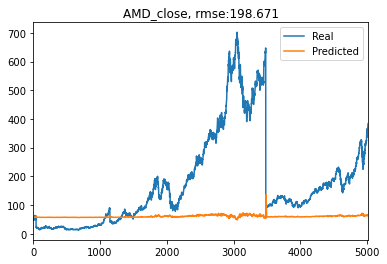

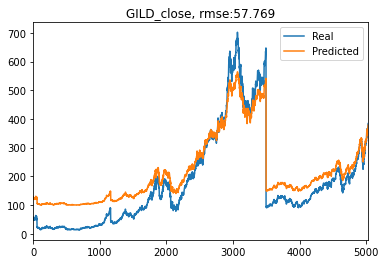

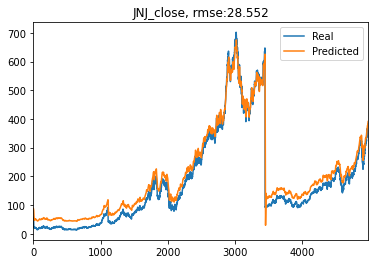

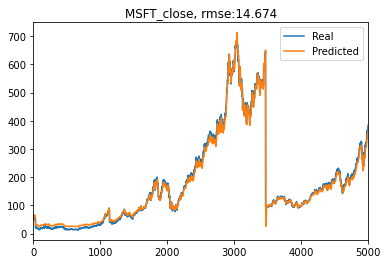

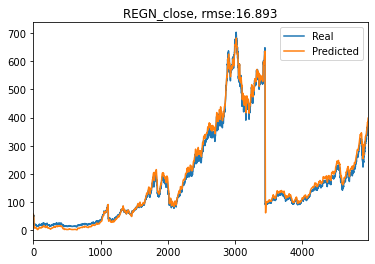

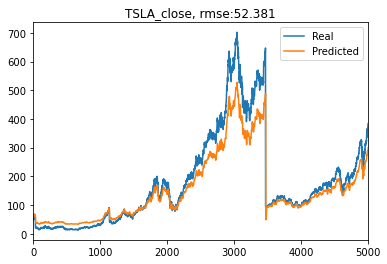

In [59]:
for index, row in df_candidates_1lstm.iterrows():
    csv_path = Path('./results/'+row['stock']+'_1lstm_model.csv')
    df_results = pd.read_csv(csv_path)
    df_results.drop(columns='Unnamed: 0', inplace=True)
    rmse = mean_squared_error(df_results.iloc[:,0],df_results.iloc[:,1], squared=False)
    df_results.plot(title=f'{row["stock"]}, rmse:{rmse:.3f}')

### 2 LSTM layers

In [73]:
# prepare AAPL data for model consumption, and predict prices using 2lstm models
for index, row in df_candidates_2lstm.iterrows():
    X_AAPL, y_AAPL = window_data(
        df=AAPL_df,
        window = row['window size'],
        feature_col_number=0,
        target_col_number=0
    )
    
    scaler = MinMaxScaler()
    X = scaler.fit(X_AAPL)
    X = scaler.transform(X_AAPL)
    y = scaler.fit(y_AAPL)
    y = scaler.transform(y_AAPL)
    
    X = X.reshape((X.shape[0], X.shape[1], 1))

#     # Load json and create model
    model_path = './models/'+row['stock']+'_2lstm_model.h5'
    
    #load model
    model = load_model(model_path)
    
    # predict prices
    predicted = model.predict(X)
    
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y.reshape(-1, 1))
    
    stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    })
    
    stocks_path = Path('./results/'+row['stock']+'_2lstm_model.csv')
    
    stocks.to_csv(stocks_path)

ValueError: Error when checking input: expected lstm_14_input to have shape (15, 1) but got array with shape (50, 1)

In [ ]:
for index, row in df_candidates_2lstm.iterrows():
    csv_path = Path('./results/'+row['stock']+'_2lstm_model.csv')
    df_results = pd.read_csv(csv_path)
    df_results.drop(columns='Unnamed: 0', inplace=True)
    rmse = mean_squared_error(df_results.iloc[:,0],df_results.iloc[:,1], squared=False)
    df_results.plot(title=f'{row["stock"]}, rmse:{rmse:.3f}')

***

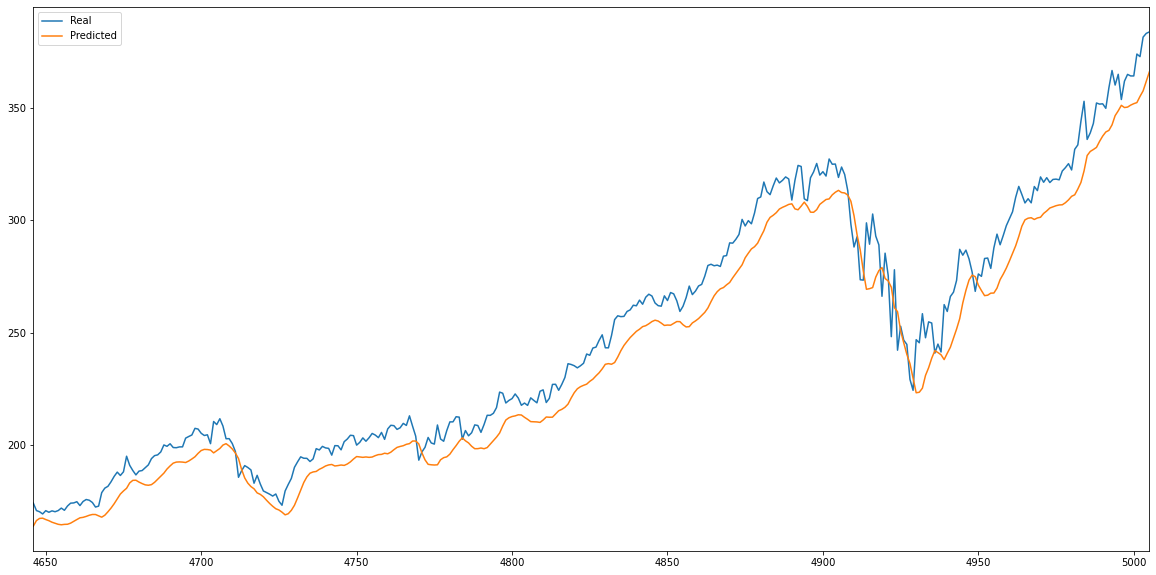

In [65]:
csv_path = Path('./results/MSFT_close_1lstm_model.csv')
df_msft_1lstm_model = pd.read_csv(csv_path)
df_msft_1lstm_model.drop(columns='Unnamed: 0', inplace=True)
rmse = mean_squared_error(df_msft_1lstm_model.iloc[:,0],df_msft_1lstm_model.iloc[:,1], squared=False)
df_msft_1lstm_model.iloc[-360:,:].plot(figsize=(20,10))

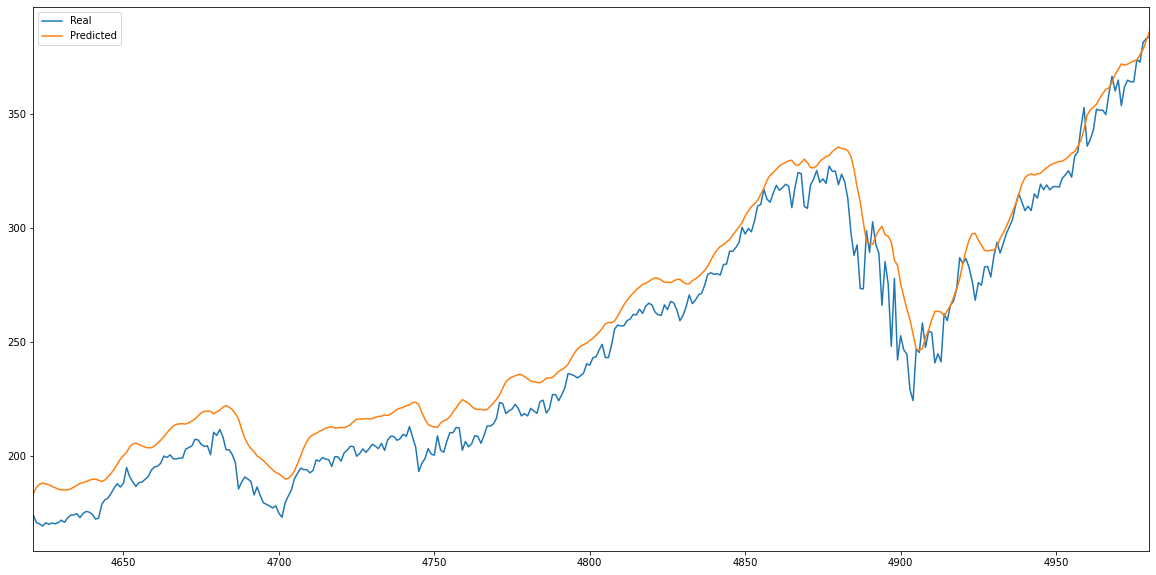

In [66]:
csv_path = Path('./results/JNJ_close_2lstm_model.csv')
df_jnj_2lstm_model = pd.read_csv(csv_path)
df_jnj_2lstm_model.drop(columns='Unnamed: 0', inplace=True)
rmse = mean_squared_error(df_jnj_2lstm_model.iloc[:,0],df_jnj_2lstm_model.iloc[:,1], squared=False)
df_jnj_2lstm_model.iloc[-360:,:].plot(figsize=(20,10))